In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from utils import *
import matplotlib.pyplot as plt
import tol_colors as tc
from scipy.optimize import minimize
from scipy.stats import yulesimon, nbinom, expon, norm, binom, lognorm
from scipy.special import betaln
import scipy.special

# Load results

In [2]:
clusters_path = '../phylogenetics/import_clusters.txt'
clusters = [[_.replace('"', '').replace('[', '').replace(']', '').strip() for _ in l.strip().split(',')] for l in open(clusters_path).readlines()]
cluster_sizes = [len(c) for c in clusters if len(c) > 0]
data = cluster_sizes

hiv_clusters_path = '../nyc_hiv/HIV_cluster_sizes.csv'
hiv_cluster_sizes = [int(l.strip().split(',')[1]) for l in open(hiv_clusters_path).readlines()[1:]]

# MPXV vs. HIV cluster sizes

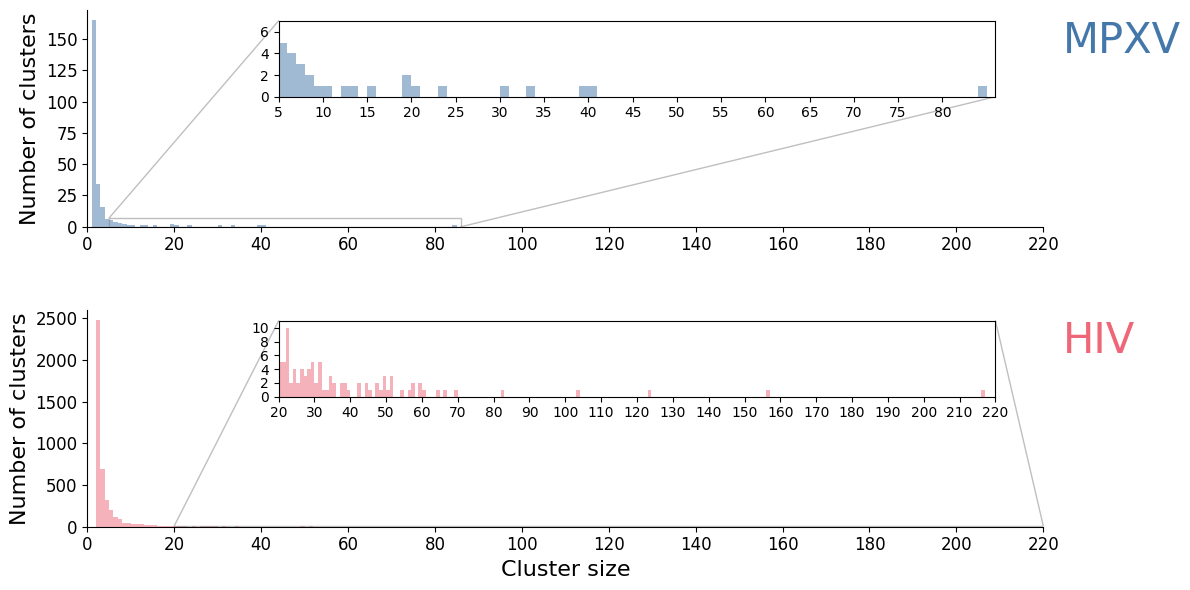

In [3]:
# plot the cluster size distribution
fig, axes = plt.subplots(2, 1, figsize=(12, 6))


ax = axes[0]
ax.hist(data, bins=range(0, max(data) + 1, 1), color=tc.tol_cset('bright')[0], alpha=0.5, label='MPXV')
ax.set_xlim(0, 220)
ax.set_xticks(range(0, 221, 20))

# add a zoomed in inset
axins = ax.inset_axes([0.2, 0.6, 0.75, 0.35])
axins.hist(data, bins=range(0, max(data) + 1, 1), color=tc.tol_cset('bright')[0], alpha=0.5)
axins.set_xlim(20, max(data) + 1)
axins.set_ylim(0, 7)
axins.set_xticks(range(5, 85, 5))
axins.set_yticks(range(0, 8, 2))
# axins.set_title('Zoomed in')
ax.indicate_inset_zoom(axins)
# set fontsize of inset
for label in axins.get_xticklabels() + axins.get_yticklabels():
    label.set_fontsize(10)
# set fontsize of plot
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(12)    

# remove top and right 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_yscale('symlog', linthresh=10)


ax = axes[1]
ax.hist(hiv_cluster_sizes, bins=range(0, max(cluster_sizes) + 1, 1), color=tc.tol_cset('bright')[1], alpha=0.5, label='MPXV')
ax.set_xlim(0, 220)
ax.set_xticks(range(0, 221, 20))

# add a zoomed in inset
axins = ax.inset_axes([0.2, 0.6, 0.75, 0.35])
axins.hist(hiv_cluster_sizes, bins=range(0, max(hiv_cluster_sizes) + 1, 1), color=tc.tol_cset('bright')[1], alpha=0.5)
axins.set_xlim(20, max(hiv_cluster_sizes) + 1)
axins.set_xticks(range(20, 221, 10))
axins.set_yticks(range(0, 13, 2))
axins.set_ylim(0, 11)
# axins.set_title('Zoomed in')
ax.indicate_inset_zoom(axins)
# set fontsize of inset
for label in axins.get_xticklabels() + axins.get_yticklabels():
    label.set_fontsize(10)
# set fontsize of plot
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(12)

# axes[0].set_xlabel('Cluster size', fontsize=16)
axes[1].set_xlabel('Cluster size', fontsize=16)
axes[0].set_ylabel('Number of clusters', fontsize=16)
axes[1].set_ylabel('Number of clusters', fontsize=16)

# remove top and right 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_yscale('symlog', linthresh=10)

labels = ['MPXV', 'HIV']
for i, ax in enumerate(axes.flatten()):
    ax.text(1.02, 0.8, labels[i], transform=ax.transAxes, size=30, color=tc.tol_cset('bright')[i])

plt.tight_layout(h_pad=4)
plt.show()

# Diagnosis dates for 328 HIV patients

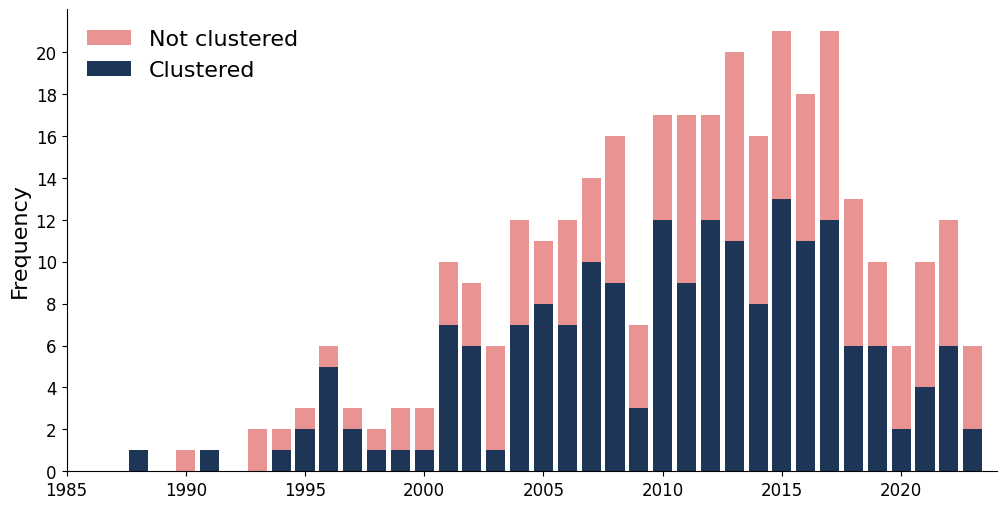

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

dx_328 = pd.read_csv('../nyc_hiv/MPXV_HIVDx.csv')
dx_187 = pd.read_csv('../nyc_hiv/MPXV_HIVGeno.csv')
cmap3 = ['#d62828', '#1d3557', '#f4a261', '#9cb29e']

# plot the cluster size distribution; stacked bar plot
plt.bar(dx_328['Diagnosis Year'], dx_328['N'], color=cmap3[0], alpha=0.5, label='Not clustered')
plt.bar(dx_187['Diagnosis Year'], dx_187['N'], color=cmap3[1], alpha=1, label='Clustered')

plt.xlim(1985, 2024)
plt.xticks(range(1985, 2025, 5), fontsize=12)

plt.yticks(range(0, 21, 2), fontsize=12)
plt.ylabel('Frequency', fontsize=16)

sns.despine()

plt.legend(fontsize=16, loc='upper left', frameon=False)
plt.show()

# Functions for AIC

In [23]:
def calculate_aic(likelihood_func, initial_guess, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    """
    Calculate the Akaike Information Criterion (AIC) for a given likelihood function.
    
    Parameters:
    - likelihood_func: Likelihood function that takes parameters and data and returns the negative log-likelihood.
    - initial_guess: Initial guess for the parameters to be optimized.
    - data: Observed data for fitting the distribution.

    Returns:
    - AIC value.
    """
    result = minimize(likelihood_func, initial_guess, args=(data, weight, min_cluster_size, prop_diff,), method='Nelder-Mead')
    likelihood = -result.fun  # Maximum likelihood
    k = len(initial_guess)  # Number of parameters
    aic = 2 * k - 2 * likelihood
    opt_params = result.x
    return aic, opt_params


def cluster_thresholds(data, min_cluster_size=1, prop_diff=0.2):
    counter_d = Counter(data)
    min_cluster_threshold = counter_d[min_cluster_size] / len(data) * (1 - prop_diff)
    max_cluster_threshold = counter_d[min_cluster_size] / len(data) * (1 + prop_diff)

    min_cluster_ratio = counter_d[min_cluster_size] / counter_d[min_cluster_size + 1] * (1 - prop_diff)
    max_cluster_ratio = counter_d[min_cluster_size] / counter_d[min_cluster_size + 1] * (1 + prop_diff)

    return min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio


def calculate_penalty(value, min_threshold, max_threshold, weight=100):

    if not isinstance(value, float):
        assert len(value) == 1
        value = value[0]

    if value <= min_threshold:
        value = abs(value - min_threshold)
    elif value >= max_threshold:
        value = abs(value - max_threshold)
    else:
        value = 0
    penalty = value * weight

    return penalty


# Define the normal likelihood function
def normal_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)
    
    mu, sigma = params

    # calculate the probability of the minimum cluster size for a penalty
    min_cluster_size_prob = np.diff(norm.cdf([min_cluster_size-.5, min_cluster_size+0.5], loc=mu, scale=sigma)) / (1 - norm.cdf(min_cluster_size-0.5, loc=mu, scale=sigma))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = np.diff(norm.cdf([min_cluster_size + .5, min_cluster_size + 1.5], loc=mu, scale=sigma)) / (1 - norm.cdf(min_cluster_size - 0.5, loc=mu, scale=sigma))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    # calculate the log likelihood and add the penalties
    log_likelihood = -np.log(norm.pdf(data, loc=mu, scale=sigma)).sum() + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the exponential likelihood function
def exponential_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)
    
    scale = params

    # calculate the probability of the minimum cluster size for a penalty
    min_cluster_size_prob = np.diff(expon.cdf([min_cluster_size - 0.5, min_cluster_size + 0.5], scale=scale)) / (1 - expon.cdf(min_cluster_size - 0.5, scale=scale))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = np.diff(expon.cdf([min_cluster_size + .5, min_cluster_size + 1.5], scale=scale)) / (1 - expon.cdf(min_cluster_size - 0.5, scale=scale))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    # calculate the log likelihood and add the penalties
    log_likelihood = -expon.logpdf(data, loc=0, scale=scale).sum() + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the binomial likelihood function
def binomial_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)

    n, p = params

    base_probability = 0
    for i in range(min_cluster_size):
        base_probability += binom.pmf([i], n, p).sum()

    # calculate the probability of the minimum cluster size for a penalty
    min_cluster_size_prob = binom.pmf([min_cluster_size], n, p) / (1 - base_probability) # np.diff(binom.cdf([min_cluster_size - 0.5, min_cluster_size + 0.5], n, p)) / (1 - binom.cdf(min_cluster_size - 0.5, n, p))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = binom.pmf([min_cluster_size + 1], n, p) / (1 - base_probability) # np.diff(binom.cdf([min_cluster_size + .5, min_cluster_size + 1.5], n, p)) / (1 - binom.cdf(min_cluster_size - 0.5, n, p))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    # calculate the log likelihood and add the penalties
    log_likelihood = -np.log(binom.pmf(data, n, p)).sum() + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the power law likelihood function --  NEED TO FINISH
def power_law_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)

    alpha = params[0]

    def power_law_cdf(x, alpha):
        return -x ** (-alpha) + 1


    def power_law_pdf(x, alpha):
        return alpha * x**(-alpha - 1)
    

    # calculate the probability of the minimum cluster size for a penalty    
    min_cluster_size_prob = (np.diff([power_law_cdf(min_cluster_size - 0.5, alpha), power_law_cdf(min_cluster_size + 0.5, alpha)])) / (1 - power_law_cdf(min_cluster_size - 0.5, alpha))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = (np.diff([power_law_cdf(min_cluster_size + 0.5, alpha), power_law_cdf(min_cluster_size + 1.5, alpha)])) / (1 - power_law_cdf(min_cluster_size - 0.5, alpha))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    # calculate the log likelihood and add the penalties
    log_likelihood = -np.sum(np.log([power_law_pdf(x, alpha) for x in data])) + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the negative binomial likelihood function -- this is discrete
def negative_binomial_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)

    r, p = params

    # calculate the probability of the minimum cluster size for a penalty
    min_cluster_size_prob = nbinom.pmf([min_cluster_size], r, p) / (1 - nbinom.pmf(min_cluster_size - 1, r, p))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = nbinom.pmf([min_cluster_size + 1], r, p) / (1 - nbinom.pmf(min_cluster_size - 1, r, p)) # np.diff(nbinom.cdf([min_cluster_size + .5, min_cluster_size + 1.5], r, p)) / (1 - nbinom.cdf(min_cluster_size - 0.5, r, p))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    # calculate the log likelihood and add the penalties
    log_likelihood = -nbinom.logpmf(data, r, p).sum() + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the Pareto likelihood function -- we want the discrete version
def pareto_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)

    s = params

    def discrete_pareto_pmf(k, alpha):
        if k < 1:
            return 0  # Probability is zero for non-positive integers
        zeta_alpha = scipy.special.zeta(alpha)
        return 1 / (k**alpha * zeta_alpha)
    

    # calculate the probability of the minimum cluster size for a penalty
    min_cluster_size_prob  = discrete_pareto_pmf(min_cluster_size, s) / (1 - discrete_pareto_pmf(min_cluster_size - 1, s))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = discrete_pareto_pmf(min_cluster_size + 1, s) / (1 - discrete_pareto_pmf(min_cluster_size - 1, s))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    # log_likelihood = -(np.log(s) * len(data) - s * np.sum(np.log(data))) + min_cluster_size_penalty
    log_likelihood = -np.sum(np.log([discrete_pareto_pmf(x, s) for x in data])) + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the Yule-Simon likelihood function
def yulesimon_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)

    p = params[0]

    # calculate the probability of the minimum cluster size for a penalty
    min_cluster_size_prob = (yulesimon.pmf([min_cluster_size], p)) / (1 - yulesimon.cdf(min_cluster_size - 1, p))
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    # calculate the probability of the second smallest cluster size for a penalty based on the ratio of the two probabilities
    min2_cluster_size_prob = (yulesimon.pmf([min_cluster_size + 1], p)) / (1 - yulesimon.cdf(min_cluster_size - 1, p))
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)

    log_likelihood = -np.log(yulesimon.pmf(data, p)).sum() + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
    return log_likelihood


# Define the beta negative binomial likelihood function --  NEED TO FINISH
def beta_negative_binomial_likelihood(params, data, weight=100, min_cluster_size=1, prop_diff=0.2):
    min_cluster_threshold, max_cluster_threshold, min_cluster_ratio, max_cluster_ratio = cluster_thresholds(data, min_cluster_size=min_cluster_size, prop_diff=prop_diff)
    
    alpha, beta, r = params
    p = alpha / (alpha + beta)  # Calculate the success probability p using the Beta distribution mean formula
    # p = np.clip(p, 1e-6, 1 - 1e-6)  # Clip p to a valid range to avoid log(0) or log(1)

    def beta_negative_binomial_logpmf(tmp_data):
        return -nbinom.logpmf(tmp_data, r, 1 - p).sum() - betaln(alpha, beta) + (alpha - 1) * np.log(p) + (beta - 1) * np.log(1 - p)


    def beta_negative_binomial_pmf(tmp_data):
        return np.exp(-beta_negative_binomial_logpmf(tmp_data))


    base_probability = 0
    for i in range(min_cluster_size):
        base_probability += beta_negative_binomial_pmf(np.array([i])).sum()

    min_cluster_size_prob = beta_negative_binomial_pmf(np.array([min_cluster_size])) / (1 - base_probability)
    min_cluster_size_penalty = calculate_penalty(min_cluster_size_prob, min_cluster_threshold, max_cluster_threshold, weight=weight)

    min2_cluster_size_prob = beta_negative_binomial_pmf(np.array([min_cluster_size + 1])) / (1 - base_probability)
    min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
    min_cluster_dist_ratio_penalty = calculate_penalty(min_cluster_dist_ratio, min_cluster_ratio, max_cluster_ratio, weight=weight)
    
    log_likelihood = beta_negative_binomial_logpmf(data) + min_cluster_size_penalty  + min_cluster_dist_ratio_penalty
    return log_likelihood




# Functions for KL divergence

In [24]:
def power_law_sampling(alpha, size=10000):
    # Generate uniform random numbers
    u = np.random.uniform(0, 1, size)

    # Inverse CDF for power-law distribution
    samples = (1 - u)**(-1/alpha)
    return samples


def beta_neg_binom_sample(alpha, beta, r, size=1):
    p = np.random.beta(alpha, beta, size)
    y = np.random.negative_binomial(r, p)
    return y


def kl_divergence_calc(sim_data, real_data=np.array(cluster_sizes), min_cluster_size=1):
    sim_data = [x for x in sim_data if x >= min_cluster_size]
    # real_data = [x for x in real_data if x >= min_cluster_size]
    # round each point in the dataset
    data = np.round(sim_data).astype(int)
    unique_numbers, counts = np.unique(data, return_counts=True) 
    counts = counts / np.sum(counts)
    num2counts = {num: count for num, count in zip(unique_numbers, counts)}

    # Calculate the KL divergence
    real_numbers, real_counts = np.unique(real_data, return_counts=True)
    real_counts = real_counts / np.sum(real_counts)

    kl_divergence = 0
    for num, count in zip(real_numbers, real_counts):
        if num not in num2counts:
            kl_divergence += count * np.log(count / 1e-5)
            continue
        kl_divergence += count * np.log(count / num2counts[num])
    # print(f"{func_name} distribution, KL divergence: {kl_divergence}")
    return kl_divergence




# Combine functions, run analysis

In [56]:
# function combining the likelihood and the KL divergence
def fit_distribution(distribution_func, initial_guess, data, simulation_function, weight=100, min_cluster_size=1, prop_diff=0.3):
    aic, params = calculate_aic(distribution_func, initial_guess, data, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)
    sim_data = simulation_function(*params, size=10000)
    kl_divergence = kl_divergence_calc(sim_data, real_data=data, min_cluster_size=min_cluster_size)
    return aic, kl_divergence

weight = 100
prop_diff = 0.3

# we should get the same answers regardless of min_cluster_size -- that does not seem to be the case!
min_cluster_size = 2
new_data = np.array(data)
new_data = new_data[new_data >= min_cluster_size]

result_dict = {'Normal' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(normal_likelihood, initial_guess=(1,10), data=new_data, simulation_function=np.random.normal, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
               'Exponential' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(exponential_likelihood, initial_guess=(1,), data=new_data, simulation_function=np.random.exponential, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'Binomial' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(binomial_likelihood, initial_guess=(220, 0.3), data=new_data, simulation_function=np.random.binomial, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'PowerLaw' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(power_law_likelihood, initial_guess=(1,), data=new_data, simulation_function=power_law_sampling, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'NegativeBinomial' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(negative_binomial_likelihood, initial_guess=(1, 0.1), data=new_data, simulation_function=np.random.negative_binomial, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'Pareto' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(pareto_likelihood, initial_guess=(1,), data=new_data, simulation_function=np.random.pareto, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'YuleSimon' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(yulesimon_likelihood, initial_guess=(0.5,), data=new_data, simulation_function=yulesimon.rvs, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'BetaNegativeBinomial' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(beta_negative_binomial_likelihood, initial_guess=(1, 1, 1), data=new_data, simulation_function=beta_neg_binom_sample, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                }

results_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(by='KL_divergence', ascending=False)

# do the same for the HIV data
hiv_data = np.array(hiv_cluster_sizes)
hiv_data = hiv_data[hiv_data >= min_cluster_size]

hiv_result_dict = {'Normal' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(normal_likelihood, initial_guess=(1,10), data=hiv_data, simulation_function=np.random.normal, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'Exponential' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(exponential_likelihood, initial_guess=(1,), data=hiv_data, simulation_function=np.random.exponential, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'Binomial' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(binomial_likelihood, initial_guess=(220, 0.3), data=hiv_data, simulation_function=np.random.binomial, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},  
                'PowerLaw' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(power_law_likelihood, initial_guess=(1,), data=hiv_data, simulation_function=power_law_sampling, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'NegativeBinomial' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(negative_binomial_likelihood, initial_guess=(1, 0.1), data=hiv_data, simulation_function=np.random.negative_binomial, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'Pareto' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(pareto_likelihood, initial_guess=(1,), data=hiv_data, simulation_function=np.random.pareto, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'YuleSimon' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(yulesimon_likelihood, initial_guess=(0.5,), data=hiv_data, simulation_function=yulesimon.rvs, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                'BetaNegativeBinomial' : {**{'AIC': 0, 'KL_divergence': 0}, **dict(zip(['AIC', 'KL_divergence'], fit_distribution(beta_negative_binomial_likelihood, initial_guess=(1, 1, 1), data=hiv_data, simulation_function=beta_neg_binom_sample, weight=weight, min_cluster_size=min_cluster_size, prop_diff=prop_diff)))},
                }

hiv_results_df = pd.DataFrame.from_dict(hiv_result_dict, orient='index').sort_values(by='KL_divergence', ascending=False)

# results change each time you run the code, but the general trend is that heavy-tailed and scale-free distributions are better fits
display(results_df), display(hiv_results_df)

/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_78493/1503386311.py:180: RuntimeWarning: invalid value encountered in divide
  min_cluster_dist_ratio = min_cluster_size_prob / min2_cluster_size_prob
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_78493/1503386311.py:184: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.sum(np.log([discrete_pareto_pmf(x, s) for x in data])) + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_78493/1503386311.py:216: RuntimeWarning: invalid value encountered in log
  return -nbinom.logpmf(tmp_data, r, 1 - p).sum() - betaln(alpha, beta) + (alpha - 1) * np.log(p) + (beta - 1) * np.log(1 - p)
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_78493/1503386311.py:109: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.log(binom.pmf(data, n, p)).sum() + min_cluster_size_penalty + min_cluster_dist_ratio_penalty
/var/fol

,AIC,KL_divergence
Binomial,1409.716332,1.736975
Normal,804.805568,1.406269
Exponential,582.725179,0.757121
NegativeBinomial,602.168739,0.517416
PowerLaw,461.878269,0.476610
BetaNegativeBinomial,570.022129,0.462953
Pareto,521.209490,0.429270
YuleSimon,507.857552,0.327366


,AIC,KL_divergence
Binomial,38082.987779,1.922401
Normal,29323.677502,1.475269
BetaNegativeBinomial,21190.205075,0.833415
Exponential,20822.705833,0.716260
NegativeBinomial,21237.043669,0.471047
PowerLaw,18483.140868,0.412863
Pareto,21929.535826,0.339222
YuleSimon,21254.078537,0.246812


(None, None)

In [57]:
results_df.columns = ['MPXV AIC', 'MPXV KL div']
hiv_results_df.columns = ['HIV AIC', 'HIV KL div']

combined_df = pd.merge(results_df, hiv_results_df, left_index=True, right_index=True)
combined_df.map(lambda x: str(round(x, 3))).to_csv('./mpxv_hiv_cluster_fit.csv')